# ANN for Image classification

In [4]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay




## Load the CIFAR-10 dataset

In [5]:
epochs = 10
batch_size = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tensor_transform = transforms.Compose([transforms.Resize(32),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_ds = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform= tensor_transform)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform= tensor_transform)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = batch_size, shuffle = True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = batch_size, shuffle = False)

100%|██████████| 170498071/170498071 [00:01<00:00, 106174991.86it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Init the model inputs, output and layer sizes

In [6]:
inputSize = 32 * 32 * 3 # Every image is 32*32 pixels with 3 RGB channels
# sizes for each hidden layer of the neural netowrk
hiddenSize1 = 4096
hiddenSize2 = 2048
hiddenSize3 = 512
outputSize = 10 # cifar-10 has 10 classes

### Defining the class to develop the neural network

In [7]:
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(ANN, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        # Apply the layers sequentially
        x = x.view(-1, 32 * 32 * 3)  # Flatten the input images
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

### Calling the model with our correct data sizes

In [8]:
model = ANN(inputSize,hiddenSize1,hiddenSize2,hiddenSize3,outputSize).to(device)


### Loss function and optimizer

In [9]:
lossFunction = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

## Training and evaluation functions

In [10]:
def training(model, lossFunction, optimizer):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_dl, 0):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad() # Clear optimizer gradient
            outputs = model(images)
            loss = lossFunction(outputs, labels)
            loss.backward() # Backpropagation to compute gradients
            optimizer.step() # Update model paramaters

            # Update stats
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


            if i % 100 == 99:  # Print every 100 batches
                avg_loss = running_loss / 100
                accuracy = correct / total
                print(f'Epoch [{epoch + 1}/{epochs}], Batch [{i + 1}/{len(train_dl)}], '
                      f'Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2%}')
                running_loss = 0.0
                correct = 0
                total = 0


def eval(model, dl):
    model.eval()
    with torch.no_grad():
        all_labels = []
        all_predictions = []
        for images, labels in dl:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    if(dl == test_dl):
        accuracy = accuracy_score(all_labels, all_predictions)
        precision = precision_score(all_labels, all_predictions, average='weighted')
        recall = recall_score(all_labels, all_predictions, average='weighted')
        confusion = confusion_matrix(all_labels, all_predictions)
        print(f"Results for testing: ")
        print(f"Accuracy: {accuracy:.2%}")
        print(f"Precision: {precision:.2%}")
        print(f"Recall: {recall:.2%}")
        confMatrix = ConfusionMatrixDisplay(confusion)
        confMatrix.plot()
    else:
        accuracy = accuracy_score(all_labels, all_predictions)
        print(f'train accuracy : {accuracy:.2%}')

## Training and evaluation

In [11]:
training(model,lossFunction,optimizer)

Epoch [1/10], Batch [100/500], Loss: 2.1494, Accuracy: 24.30%
Epoch [1/10], Batch [200/500], Loss: 1.8015, Accuracy: 35.55%
Epoch [1/10], Batch [300/500], Loss: 1.6844, Accuracy: 39.58%
Epoch [1/10], Batch [400/500], Loss: 1.6381, Accuracy: 42.04%
Epoch [1/10], Batch [500/500], Loss: 1.5918, Accuracy: 43.37%
Epoch [2/10], Batch [100/500], Loss: 1.4946, Accuracy: 47.20%
Epoch [2/10], Batch [200/500], Loss: 1.4711, Accuracy: 48.06%
Epoch [2/10], Batch [300/500], Loss: 1.4304, Accuracy: 49.69%
Epoch [2/10], Batch [400/500], Loss: 1.4235, Accuracy: 49.22%
Epoch [2/10], Batch [500/500], Loss: 1.4145, Accuracy: 50.40%
Epoch [3/10], Batch [100/500], Loss: 1.3184, Accuracy: 53.09%
Epoch [3/10], Batch [200/500], Loss: 1.3233, Accuracy: 53.51%
Epoch [3/10], Batch [300/500], Loss: 1.3049, Accuracy: 54.02%
Epoch [3/10], Batch [400/500], Loss: 1.3010, Accuracy: 53.83%
Epoch [3/10], Batch [500/500], Loss: 1.2828, Accuracy: 54.61%
Epoch [4/10], Batch [100/500], Loss: 1.1892, Accuracy: 57.96%
Epoch [4

In [12]:
eval(model,train_dl)

train accuracy : 83.63%


Results for testing: 
Accuracy: 56.64%
Precision: 57.34%
Recall: 56.64%


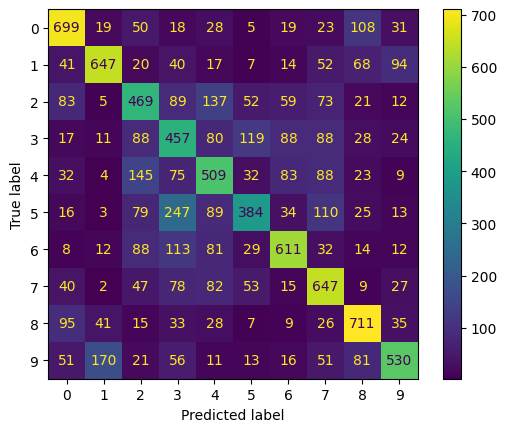

In [13]:
eval(model,test_dl)

# Using transfer learning with CNNs

## Loading the models

In [14]:
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, outputSize)
vgg16 = vgg16.to(device)
vgg16_optimizer = torch.optim.SGD(vgg16.parameters(), lr=0.01, momentum=0.9)

googlenet = torchvision.models.googlenet(pretrained=True)
googlenet.fc = nn.Linear(googlenet.fc.in_features, outputSize)
googlenet = googlenet.to(device)
googlenet_optimizer = torch.optim.SGD(googlenet.parameters(), lr=0.01, momentum=0.9)

resnet = torchvision.models.resnet50(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, outputSize)
resnet_model = resnet.to(device)
resnet_model_optimizer = torch.optim.SGD(resnet.parameters(), lr=0.01, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 87.9MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future.

## Training and evaluating models

## VGG16

VGG16:
Epoch [1/10], Batch [100/500], Loss: 1.2667, Accuracy: 56.38%
Epoch [1/10], Batch [200/500], Loss: 0.7988, Accuracy: 73.46%
Epoch [1/10], Batch [300/500], Loss: 0.6836, Accuracy: 77.42%
Epoch [1/10], Batch [400/500], Loss: 0.6108, Accuracy: 80.17%
Epoch [1/10], Batch [500/500], Loss: 0.5901, Accuracy: 80.78%
Epoch [2/10], Batch [100/500], Loss: 0.4047, Accuracy: 86.81%
Epoch [2/10], Batch [200/500], Loss: 0.4270, Accuracy: 85.74%
Epoch [2/10], Batch [300/500], Loss: 0.4035, Accuracy: 86.39%
Epoch [2/10], Batch [400/500], Loss: 0.4179, Accuracy: 86.35%
Epoch [2/10], Batch [500/500], Loss: 0.3903, Accuracy: 87.03%
Epoch [3/10], Batch [100/500], Loss: 0.2686, Accuracy: 91.07%
Epoch [3/10], Batch [200/500], Loss: 0.2639, Accuracy: 91.31%
Epoch [3/10], Batch [300/500], Loss: 0.2766, Accuracy: 91.04%
Epoch [3/10], Batch [400/500], Loss: 0.2717, Accuracy: 90.92%
Epoch [3/10], Batch [500/500], Loss: 0.2809, Accuracy: 90.79%
Epoch [4/10], Batch [100/500], Loss: 0.1820, Accuracy: 93.88%
E

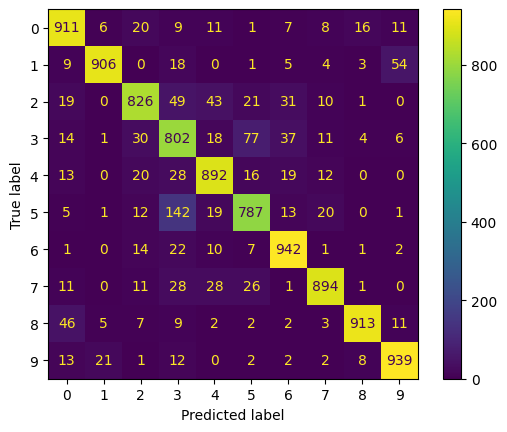

In [15]:
print("VGG16:")
training(vgg16, lossFunction, vgg16_optimizer)
eval(vgg16, train_dl)
eval(vgg16, test_dl)

## GoogleNet

GoogleNet:
Epoch [1/10], Batch [100/500], Loss: 1.6124, Accuracy: 43.45%
Epoch [1/10], Batch [200/500], Loss: 1.0427, Accuracy: 64.06%
Epoch [1/10], Batch [300/500], Loss: 0.8846, Accuracy: 68.95%
Epoch [1/10], Batch [400/500], Loss: 0.8281, Accuracy: 71.74%
Epoch [1/10], Batch [500/500], Loss: 0.7995, Accuracy: 73.22%
Epoch [2/10], Batch [100/500], Loss: 0.6180, Accuracy: 79.06%
Epoch [2/10], Batch [200/500], Loss: 0.6164, Accuracy: 78.73%
Epoch [2/10], Batch [300/500], Loss: 0.6258, Accuracy: 78.57%
Epoch [2/10], Batch [400/500], Loss: 0.5917, Accuracy: 79.35%
Epoch [2/10], Batch [500/500], Loss: 0.5806, Accuracy: 80.26%
Epoch [3/10], Batch [100/500], Loss: 0.4308, Accuracy: 85.14%
Epoch [3/10], Batch [200/500], Loss: 0.4235, Accuracy: 85.49%
Epoch [3/10], Batch [300/500], Loss: 0.4651, Accuracy: 84.28%
Epoch [3/10], Batch [400/500], Loss: 0.4560, Accuracy: 84.18%
Epoch [3/10], Batch [500/500], Loss: 0.4484, Accuracy: 84.40%
Epoch [4/10], Batch [100/500], Loss: 0.3192, Accuracy: 89.1

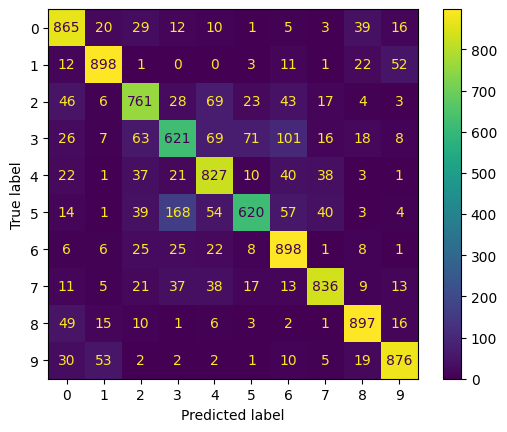

In [16]:
print("GoogleNet:")
training(googlenet, lossFunction, googlenet_optimizer)
eval(googlenet, train_dl)
eval(googlenet, test_dl)

## ResNet50

ResNet:
Epoch [1/10], Batch [100/500], Loss: 1.4343, Accuracy: 51.36%
Epoch [1/10], Batch [200/500], Loss: 0.8814, Accuracy: 70.52%
Epoch [1/10], Batch [300/500], Loss: 0.7314, Accuracy: 74.95%
Epoch [1/10], Batch [400/500], Loss: 0.6770, Accuracy: 77.17%
Epoch [1/10], Batch [500/500], Loss: 0.6044, Accuracy: 79.31%
Epoch [2/10], Batch [100/500], Loss: 0.4458, Accuracy: 85.21%
Epoch [2/10], Batch [200/500], Loss: 0.4739, Accuracy: 83.70%
Epoch [2/10], Batch [300/500], Loss: 0.4644, Accuracy: 84.13%
Epoch [2/10], Batch [400/500], Loss: 0.4368, Accuracy: 85.11%
Epoch [2/10], Batch [500/500], Loss: 0.4634, Accuracy: 84.02%
Epoch [3/10], Batch [100/500], Loss: 0.2973, Accuracy: 89.84%
Epoch [3/10], Batch [200/500], Loss: 0.3035, Accuracy: 89.32%
Epoch [3/10], Batch [300/500], Loss: 0.3050, Accuracy: 89.48%
Epoch [3/10], Batch [400/500], Loss: 0.3445, Accuracy: 88.11%
Epoch [3/10], Batch [500/500], Loss: 0.3334, Accuracy: 88.45%
Epoch [4/10], Batch [100/500], Loss: 0.1926, Accuracy: 93.66%


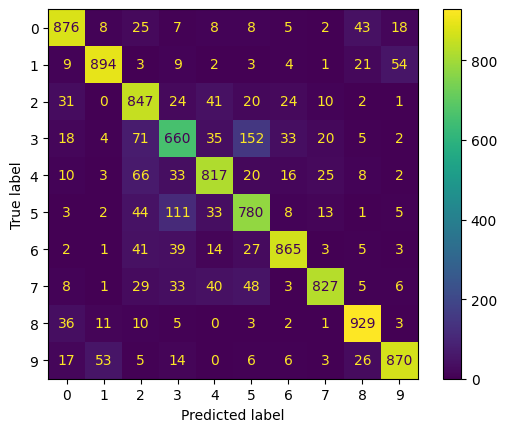

In [17]:
print("ResNet:")
training(resnet, lossFunction, resnet_model_optimizer)
eval(resnet, train_dl)
eval(resnet, test_dl)